Hi guys, Exploratory Data Analysis(EDA) is all about getting insight from datasets, and if this process is followed properly then we get some really good understanding of the features and distributions we have. In depth EDA certainly results in outstanding Feature Engineering which eventually leaves heavy impact on model performance.

**Update:** I've added a simple recommendation model using Keras, later we'll do more improvisation.

This is a random exercise that I have performed. Here I've used 100K movie rating's older dataset provided by Movie Lens (https://grouplens.org/datasets/movielens/) but If you want, you can use 1M dataset as well.

### Importing Libraries and reading datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from uszipcode import SearchEngine


%matplotlib inline

In [2]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

rating_df = pd.read_csv('../input/u.data', sep='\t', 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                        parse_dates=['timestamp'], 
                        date_parser=dateparse)

movie_df = pd.read_csv('../input/u.item', sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('../input/u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

In [3]:
movie_df.sample(10)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
108,109,Mystery Science Theater 3000: The Movie (1996),19-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Mystery%20Sci...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1293,1294,Ayn Rand: A Sense of Life (1997),13-Feb-1998,NaN,http://us.imdb.com/Title?Ayn+Rand%3A+A+Sense+o...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1556,1557,Yankee Zulu (1994),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Yankee%20Zulu...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
36,37,Nadja (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Nadja%20(1994),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
127,128,Supercop (1992),26-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Police%20Stor...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
567,568,Speed (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Speed%20(1994/I),0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
309,310,"Rainmaker, The (1997)",01-Jan-1997,NaN,"http://us.imdb.com/M/title-exact?Rainmaker,+Th...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
608,609,Father of the Bride (1950),01-Jan-1950,NaN,http://us.imdb.com/M/title-exact?Father%20of%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1384,1385,Roseanna's Grave (For Roseanna) (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Roseanna%27s+...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
329,330,187 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?187+(1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Exploring 'item_df' - 

In [4]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
movie_title           1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
imdb_url              1679 non-null object
unknown               1682 non-null int64
action                1682 non-null int64
adventure             1682 non-null int64
animation             1682 non-null int64
childrens             1682 non-null int64
comedy                1682 non-null int64
crime                 1682 non-null int64
documentary           1682 non-null int64
drama                 1682 non-null int64
fantasy               1682 non-null int64
film_noir             1682 non-null int64
horror                1682 non-null int64
musical               1682 non-null int64
mystery               1682 non-null int64
romance               1682 non-null int64
sci_fi                1682 non-null int64
thriller 

In [5]:
movie_df.sample(6)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
1486,1487,Even Cowgirls Get the Blues (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Even%20Cowgir...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1158,1159,Stalker (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Stalker%20(1979),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
917,918,City of Angels (1998),03-Apr-1998,NaN,http://us.imdb.com/Title?City+of+Angels+(1998),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
389,390,Fear of a Black Hat (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Fear%20of%20a...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
480,481,"Apartment, The (1960)",01-Jan-1960,NaN,"http://us.imdb.com/M/title-exact?Apartment,%20...",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1058,1059,Don't Be a Menace to South Central While Drink...,01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Don't%20Be%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
movie_df.describe()

,movie_id,video_release_date,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
count,1682.000000,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,841.500000,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,485.695893,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,421.250000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,841.500000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1261.750000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Observations:
    1. video_release_date seems containing lots of NaN values.
    2. release_date needs to be parsed to datetime.
    3. imdb_url contains external links which is not usefull here anyways.

In [7]:
movie_df.release_date = pd.to_datetime(movie_df.release_date)

### Checkout NaN values percent in each column

In [8]:
def check_nan_percent(df):
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

In [9]:
check_nan_percent(movie_df)

,null_percent,total_null
release_date,0.059453,1
video_release_date,100.000000,1682
imdb_url,0.178359,3


Clearly video_release_date contains nothing and imdb_url is of no use, lets remove them. In release_date we have only null value, if we remove entire row, then it will cost us one missing movie_id which is not good. So lets fill it with mode value of same column, since this approach is not gonna harm much.

In [10]:
movie_df.drop(columns=['video_release_date', 'imdb_url'], inplace=True)
movie_df.release_date.fillna(value=movie_df.release_date.mode()[0], inplace=True)

check_nan_percent(movie_df)

,null_percent,total_null


Cool

### Exploring rating_df

In [11]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
movie_id     100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB


In [12]:
rating_df.sample(6)

,user_id,movie_id,rating,timestamp
10667,178,98,5,1997-12-22 21:42:24
28996,84,543,5,1997-12-30 03:48:33
5459,332,1188,5,1998-02-21 21:59:34
62681,655,209,3,1998-02-14 16:30:31
53244,406,284,1,1997-11-14 20:39:47
22630,263,1126,5,1998-03-30 22:53:11


In [13]:
rating_df.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


Observations:
    1. Everything seems all ok.

#### Check missing values

In [14]:
check_nan_percent(rating_df)

,null_percent,total_null


perfect, we don't have any missing value.

### Exploring user_df

In [15]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


In [16]:
user_df.sample(6)

,user_id,age,gender,occupation,zip_code
208,209,33,F,educator,85710
50,51,28,M,educator,16509
16,17,30,M,programmer,06355
385,386,36,M,salesman,43221
347,348,24,F,student,45660
478,479,30,M,educator,55409


Zip codes can be converted to city names, let's do that, and later we can use it for some additional analysis.

In [17]:
search = SearchEngine(simple_zipcode=True)
user_df['city'] = user_df.zip_code.apply(lambda zip: search.by_zipcode(zip).major_city)

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [18]:
user_df.describe()

,user_id,age
count,943.000000,943.000000
mean,472.000000,34.051962
std,272.364951,12.192740
min,1.000000,7.000000
25%,236.500000,25.000000
50%,472.000000,31.000000
75%,707.500000,43.000000
max,943.000000,73.000000


#### Check missing values

In [19]:
check_nan_percent(user_df)

,null_percent,total_null
city,3.923648,37


37 zip codes can not be converted to city names. Lets check these records

In [20]:
user_df[user_df.city.isnull()]

,user_id,age,gender,occupation,zip_code,city
53,54,22,M,executive,66315,None
72,73,24,M,student,41850,None
73,74,39,M,scientist,T8H1N,None
85,86,26,M,administrator,46005,None
144,145,31,M,entertainment,V3N4P,None
166,167,37,M,other,L9G2B,None
185,186,39,F,executive,00000,None
193,194,38,M,administrator,02154,None
200,201,27,M,writer,E2A4H,None
332,333,47,M,other,V0R2M,None


In all these cases zip codes seems invalid. Again removing these records completely will bring inconsistency, so better we fill these value with mode of the column.

In [21]:
user_df.city.fillna(value=user_df.city.mode()[0], inplace=True)

## Finding Insight - 

I believe the best way to do that is by asking usefull questions from dataset, and not moving forward till you get the answers.

__QA. From movie_df -__
   1. [What are common genere of movies?](#QA1)
   2. [How many movies got released each year and month?](#QA2)
   3. [What is the prefferable week of month to release movies?](#QA3)

__QB. From movie_df -__
   1. [Who watches more movies Men/Women?](#QB1)
   2. [What age group watches more movies?](#QB2)
   3. [Which kind of occupant watches more movies?](#QB3)
    
__QC. From movie_df + user_df -__
   1. [What gender likes which kind of genere](#QC1)
   2. [What age group watches which kind of movies?](#QC2)
   3. [Are movie lover's increasing over time](#QC3)
      1. [Overall](#QC3a)
      2. [Gender wise](#QC3b)
      3. [Age group wise](#QC3c)

__QD. From movie_df + user_df + rating_df__
   1. [How much rating people give mostly.](#QD1)
   2. [Most Rated Movies](#QD2)
      1. [during all years](#QD2a)
      3. [gender wise](#QD2c)
      4. [age group wise](#QD2d)
   3. [Most Loved Movies](#QD3)
      1. [during all years](#QD3a)
      3. [gender wise](#QD3c)
      4. [age group wise](#QD3d)
   4. [Worst movie as per user rating.](QD4)

If you notice at various places, we have used word age group, which is not already there, so lets go ahead and create one additional categorical feature in user_df called __age_group__. Minimum age is 7 and maximum age is 73 so we should have following divisions:

* 5-12   -  Gradeschooler
* 13-19  -  Teenager
* 20-35  -  Young
* 35-55  -  Midlife
* above 55    -  Old

In [22]:
user_df['age_group'] = user_df.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))
user_df.sample(5)

,user_id,age,gender,occupation,zip_code,city,age_group
76,77,30,M,technician,29379,Union,Young
879,880,13,M,student,83702,Boise,Teenager
115,116,40,M,healthcare,97232,Portland,Midlife
630,631,18,F,student,38866,Saltillo,Teenager
46,47,53,M,marketing,07102,Newark,Midlife


Lets also create joined DataFrames, they will be helpful later.

In [23]:
rating_user_df = rating_df.join(other=user_df, how='inner', on='user_id', lsuffix='_R')
rating_user_movie_df = rating_user_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')
rating_movie_df = rating_df.join(other=movie_df, how='inner', on='movie_id', rsuffix='_M')

### <a id='QA1'>What are common genere of movies?</a>

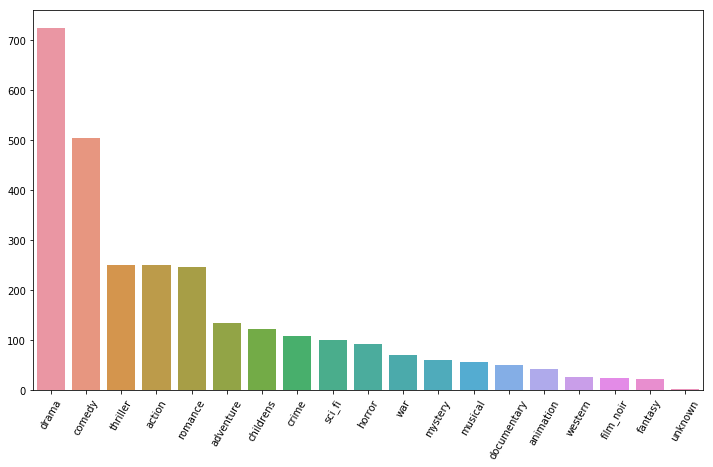

In [24]:
generes = ['unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
       'romance', 'sci_fi', 'thriller', 'war', 'western']

plt.figure(figsize=(12,7))
genere_counts = movie_df.loc[:,generes].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=60);

drama and comedy are the most common genere type. We must also note that it can not be a clear indication of people's preference, because One movie can have more than one genere and drama is the most commor genere type.

### <a id="QA2">How many movies got released each year and month?</a>

Yearly release

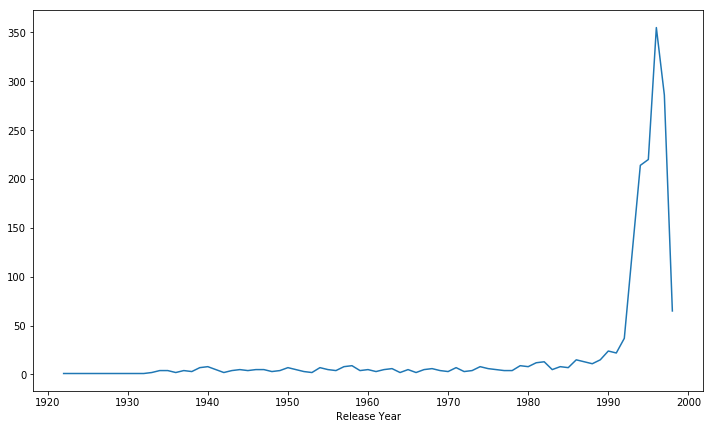

In [25]:
plt.figure(figsize=(12,7))
yearly_release_counts = movie_df.groupby(movie_df.release_date.dt.year).size().sort_values(ascending=False)
sns.lineplot(yearly_release_counts.index, yearly_release_counts.values);
plt.xlabel('Release Year');

#release significantly increased after 80s, however it doesn't exactly depicts the actual number of release, but the number of rated release, actual number of release must be far greater than what we have. Anyway, one thing is clear that people mostly watched movies released in 90s. There is a sudden fall in 1998's record, that might be because of incomplete record.

Since there is not much record available for movies before 90s, so I will consider release count for months in 90s only.`

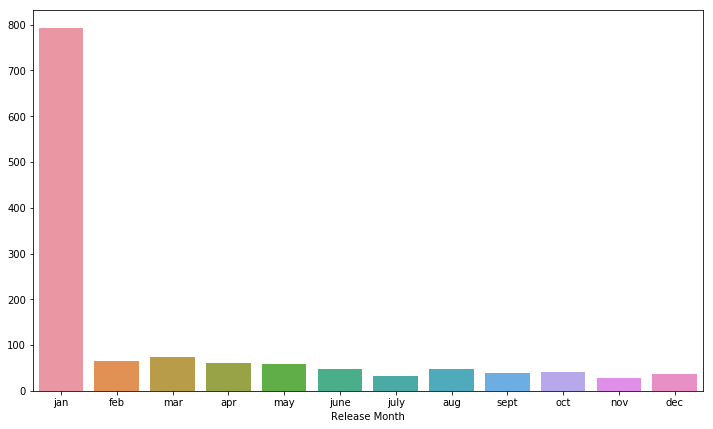

In [26]:
plt.figure(figsize=(12,7))
monthly_release_counts = movie_df[movie_df.release_date.dt.year > 1990].groupby(movie_df.release_date.dt.month).size()
sns.barplot(['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sept', 'oct', 'nov', 'dec'], monthly_release_counts.values);
plt.xlabel('Release Month');

this is weird, rated movie rlease count in Jan month is too high as cmpare to other months. Dataset creators must have considered Jan 1st as the default release month and date.

### <a id="QA3">What is the prefferable week of month to release movies?</a>

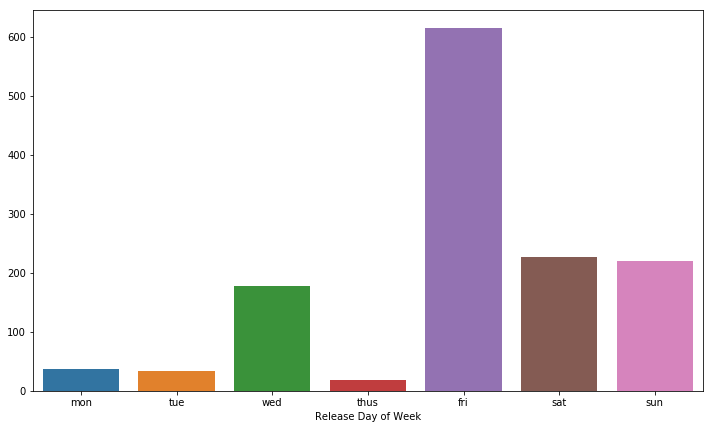

In [27]:
plt.figure(figsize=(12,7))
weekday_release_counts = movie_df[movie_df.release_date.dt.year > 1990].groupby(movie_df.release_date.dt.dayofweek).size()
sns.barplot(['mon', 'tue', 'wed', 'thus', 'fri', 'sat', 'sun'], weekday_release_counts.values);
plt.xlabel('Release Day of Week');

This trend seems fine. Mostly rated movies got released on Friday, and then on weekends.

### <a id='QB1'>Who watches more movies Men/Women?</a>

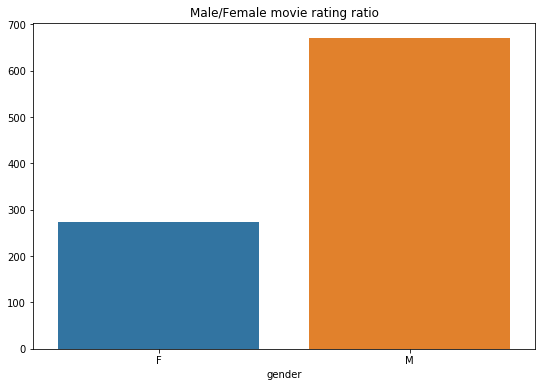

In [28]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('gender').size().index, user_df.groupby('gender').size().values)
plt.title('Male/Female movie rating ratio');

Male, of course ;)
or may be mostly Male takes interest in rating movies.

### <a id='QB2'>What age group watches more movies?</a>

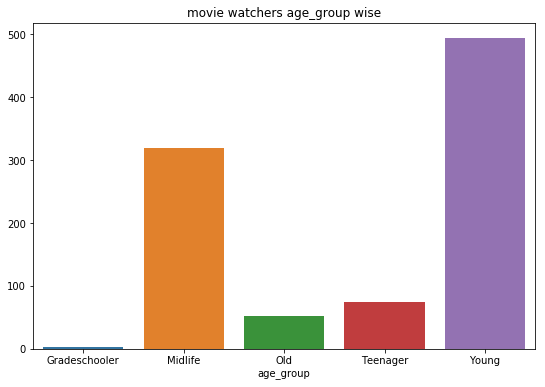

In [29]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('age_group').size().index, user_df.groupby('age_group').size().values)
plt.title('movie watchers age_group wise');

Obviously Gradeschoolers and Teenagers don't have that much of time and old people don't have much interestest. Youngesters are the ones who watches movies mostly and prefers rating them. So overall people from age 20 - 55 watches more movies.

### <a id='QB3'>Which kind of occupant watches more movies?</a>

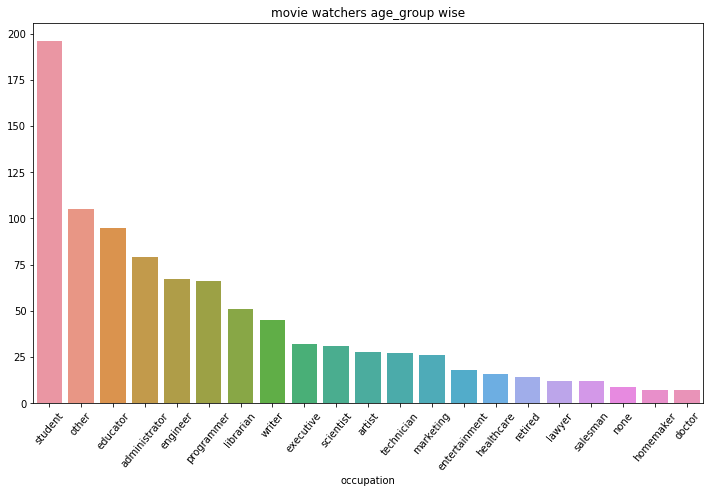

In [30]:
plt.figure(figsize=(12,7))
movie_watcher_occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(movie_watcher_occupants.index, movie_watcher_occupants.values)
plt.title('movie watchers age_group wise')
plt.xticks(rotation=50);

It appears that Students watches more movies, may be the ones who are above 20 means Young students. Irony is that people who are in entertainment don't watch or may rate movies. Lets explore it bit more.

In [31]:
pd.DataFrame(user_df.groupby(['occupation', 'age_group']).size().sort_values(ascending=False))

0
occupation    age_group         
student       Young          128
              Teenager        62
other         Young           59
educator      Midlife         51
programmer    Young           45
other         Midlife         39
administrator Midlife         38
              Young           36
educator      Young           33
engineer      Young           33
              Midlife         28
librarian     Midlife         25
              Young           22
writer        Midlife         21
              Young           20
technician    Young           19
programmer    Midlife         19
artist        Young           18
executive     Midlife         18
scientist     Midlife         17
marketing     Midlife         14
scientist     Young           14
retired       Old             13
entertainment Young           12
executive     Young           12
marketing     Young           12
educator      Old             11
healthcare    Midlife         10
artist        Midlife          9
technician    Midlife          8
...                          ...
engineer      Old              6
none          Young            5
administrator Old              5
healthcare    Young            5
homemaker     Young            5
lawyer        Midlife          5
doctor        Midlife          4
librarian     Old              4
other         Teenager         4
entertainment Midlife          4
student       Midlife          4
other         Old              3
writer        Old              2
doctor        Young            2
homemaker     Midlife          2
entertainment Teenager         2
executive     Old              2
salesman      Old              2
student       Gradeschooler    2
writer        Teenager         2
none          Teenager         2
programmer    Old              2
salesman      Midlife          2
healthcare    Old              1
none          Gradeschooler    1
doctor        Old              1
none          Midlife          1
artist        Teenager         1
retired       Midlife          1
salesman      Teenager         1

[62 rows x 1 columns]

From above dataframe it is clear that Young students are more interested in movies. After that Midelife people in any profession seems interested too.

### <a id='QC1'>What gender likes which kind of genere</a>

In [32]:
temp_df = rating_user_movie_df.groupby('gender').sum().loc[:,generes]
temp_df = temp_df.transpose()
temp_df

gender,F,M
unknown,12,26
action,6297,14761
adventure,3451,8256
animation,1143,2665
childrens,2433,5809
comedy,9437,22131
crime,2342,5429
documentary,526,1188
drama,11523,27333
fantasy,407,1025


Stacked Bar Chart-

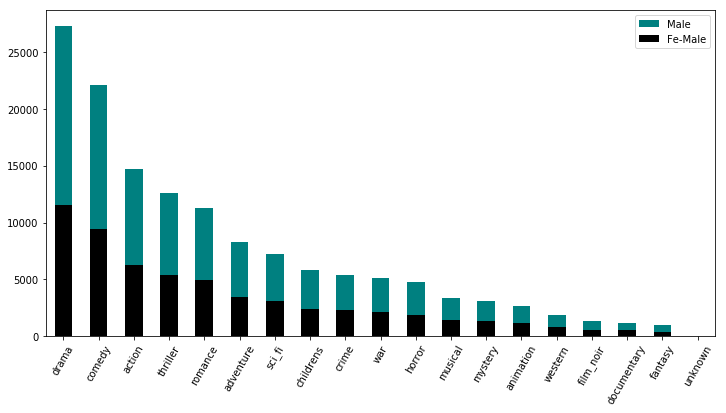

In [33]:
plt.figure(figsize=(12, 6))

temp_df.M.sort_values(ascending=False).plot(kind='bar', color='teal', label="Male")
temp_df.F.sort_values(ascending=False).plot(kind='bar', color='black', label="Fe-Male")
plt.legend()
plt.xticks(rotation=60)
plt.show()

Multi Car Chart - 

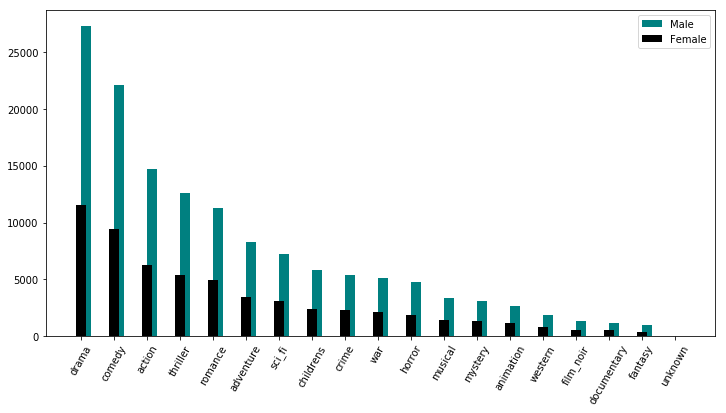

In [34]:
plt.figure(figsize=(12, 6))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='teal')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='black')
plt.legend()
plt.xticks(rotation=60)
plt.show()

Looks cool.. isn't it.

### <a id='QC2'>What age group watches which kind of movies?</a>

### <a id='QC3'>Are movie lover's increasing over time</a>

####      <a id='QC3a'>Overall</a>

In [35]:
rating_df.groupby(rating_df.timestamp.dt.year).size()

timestamp
1997    52899
1998    47101
dtype: int64

We have rating record for only two years. Which is not enought for this observation.

####      <a id='QC3b'>Gender wise</a>

In [36]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'gender']).size()

timestamp  gender
1997       F         18311
           M         34550
1998       F         11474
           M         35497
dtype: int64

We don't have enough record in ratings dataset :/

####      <a id='QC3c'>Age group wise</a>

In [37]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'age_group']).size()

timestamp  age_group    
1997       Gradeschooler       91
           Midlife          18482
           Old               2439
           Teenager          4459
           Young            27390
1998       Gradeschooler       75
           Midlife          18020
           Old               2832
           Teenager          3453
           Young            22591
dtype: int64

We don't have enough record in ratings dataset :/

### <a id='QD1'>How much rating people give mostly.</a>

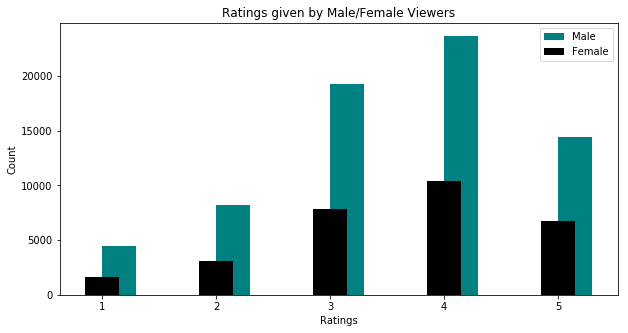

In [38]:
temp_df = rating_user_df.groupby(['gender', 'rating']).size()
plt.figure(figsize=(10, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='teal')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='black')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Viewers gave mostly 4 start rating then 3 and then 5

### <a id='QD2'>Most Rated Movies</a>

####      <a id='QD2a'>during all years</a>

In [39]:
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(12, 7))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Movies')
    plt.xlabel('Count')
    plt.show()

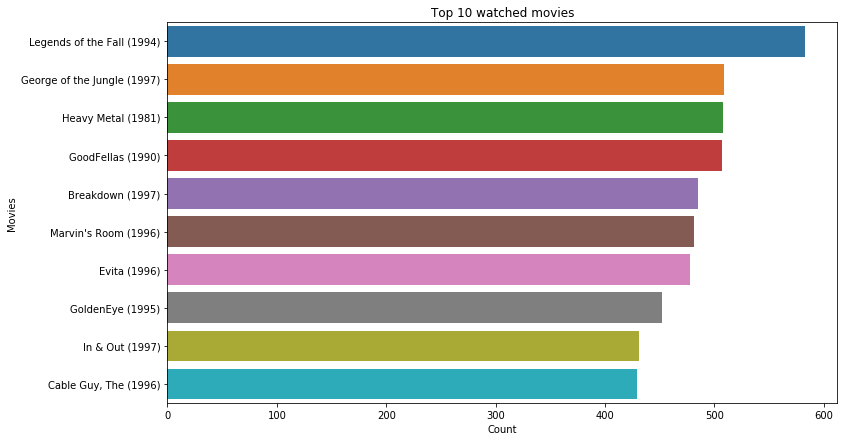

In [40]:
top_ten_rated_movies = rating_movie_df.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = movie_df.iloc[top_ten_rated_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 watched movies')

####      <a id='QD2c'>gender wise</a>

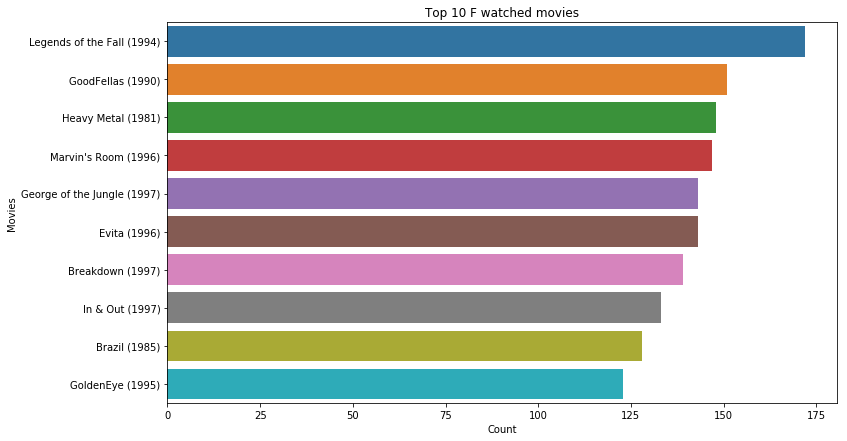

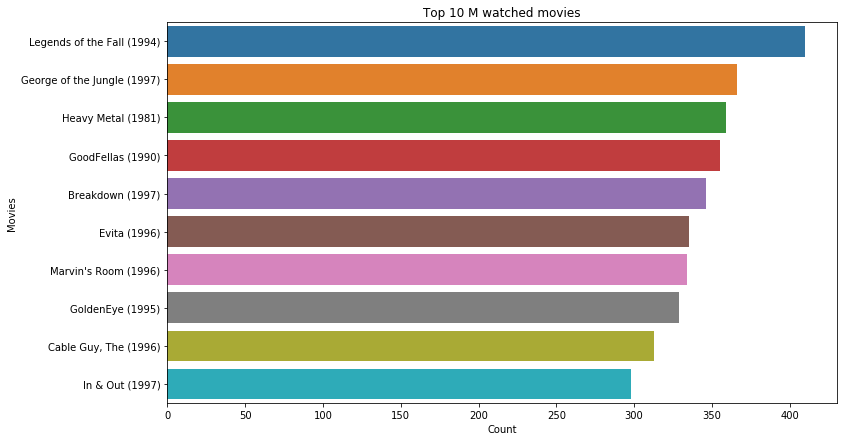

In [41]:
top_rated_movies_gender_wise = rating_user_movie_df.groupby(['gender','movie_id']).size()

for index_label in top_rated_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_rated_movies = top_rated_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = movie_df.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

####      <a id='QD2d'>age group wise</a>

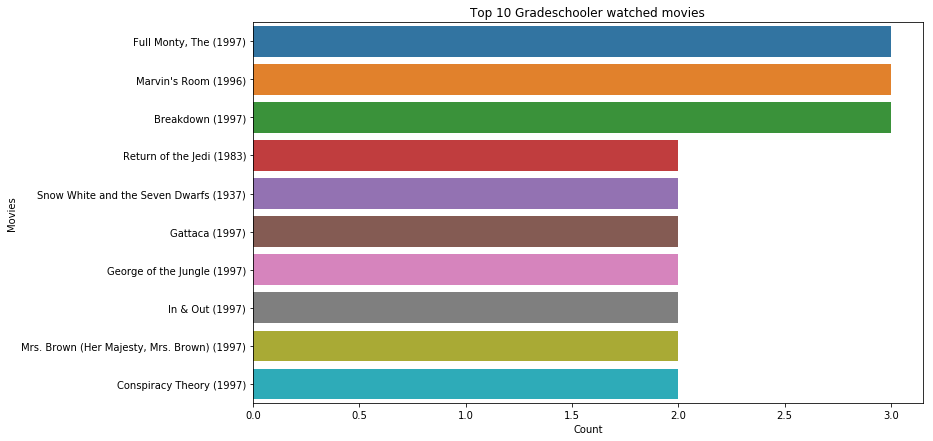

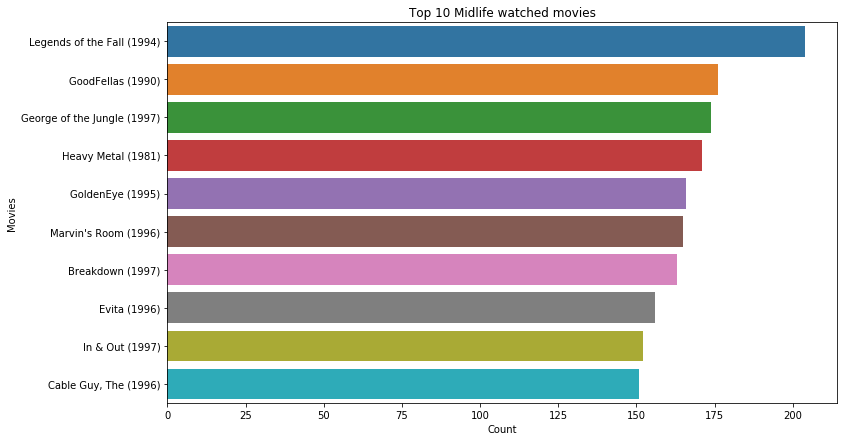

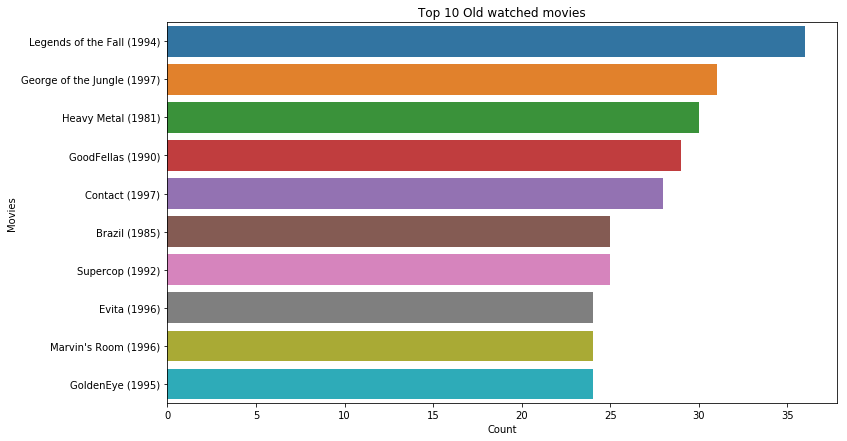

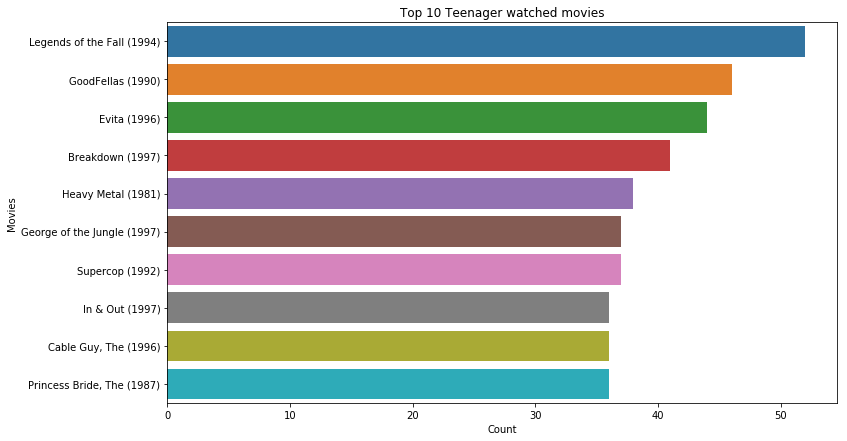

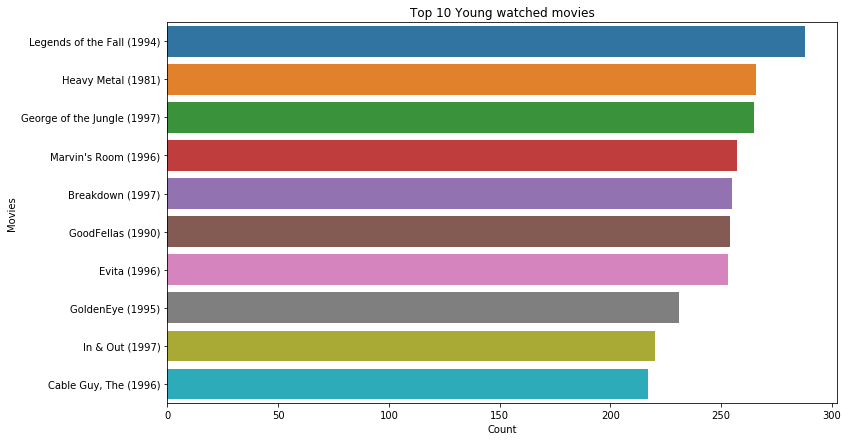

In [42]:
top_rated_movies_age_group_wise = rating_user_movie_df.groupby(['age_group','movie_id']).size()

for index_label in top_rated_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_rated_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = movie_df.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

Mostly movies are same for all user kinds, may be because of limited record we have in our ratings dataset

### <a id='QD3'>Most Loved Movies</a>

####      <a id='QD3a'>during all years</a>

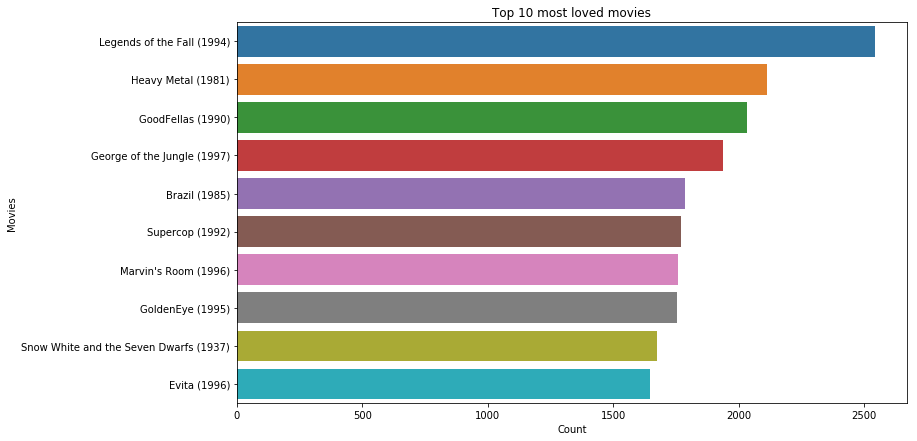

In [43]:
top_ten_most_loved_movies = rating_movie_df.groupby('movie_id').sum().rating.sort_values(ascending=False)[:10]
top_ten_most_loved_movie_titles = movie_df.iloc[top_ten_most_loved_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_most_loved_movie_titles.values, top_ten_most_loved_movies.values, 'Top 10 most loved movies')

####      <a id='QD3c'>gender wise</a>

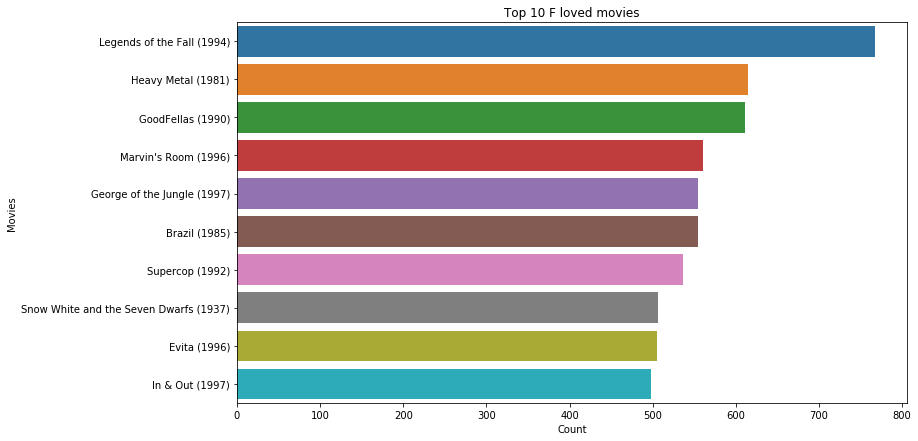

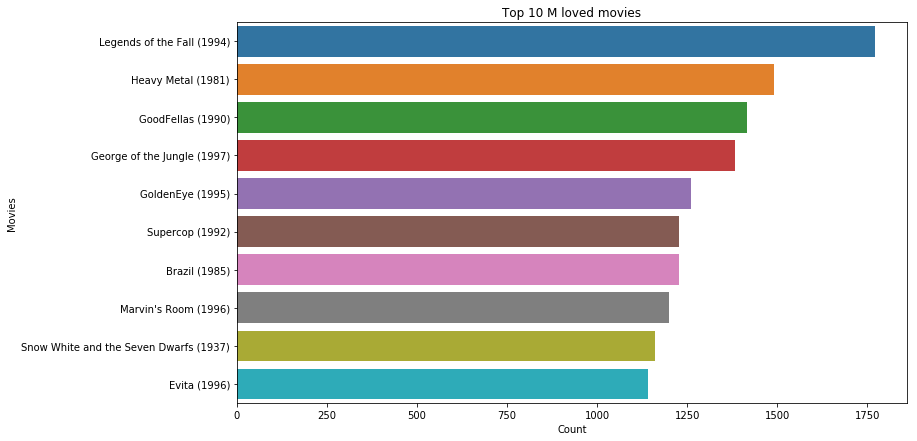

In [44]:
most_loved_movies_gender_wise = rating_user_movie_df.groupby(['gender','movie_id']).sum().rating

for index_label in most_loved_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_loved_movies = most_loved_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_loved_movie_titles = movie_df.iloc[top_10_userkind_loved_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_loved_movie_titles.values, top_10_userkind_loved_movies.values, f'Top 10 {index_label} loved movies')

####      <a id='QD3d'>age group wise</a>

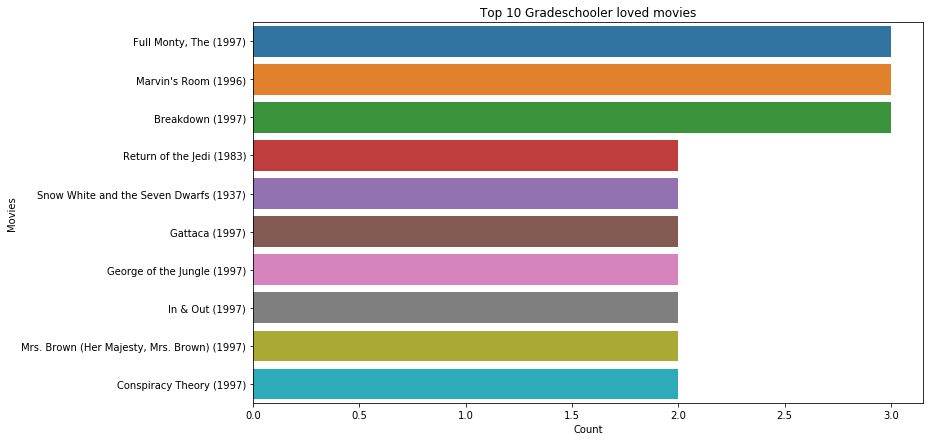

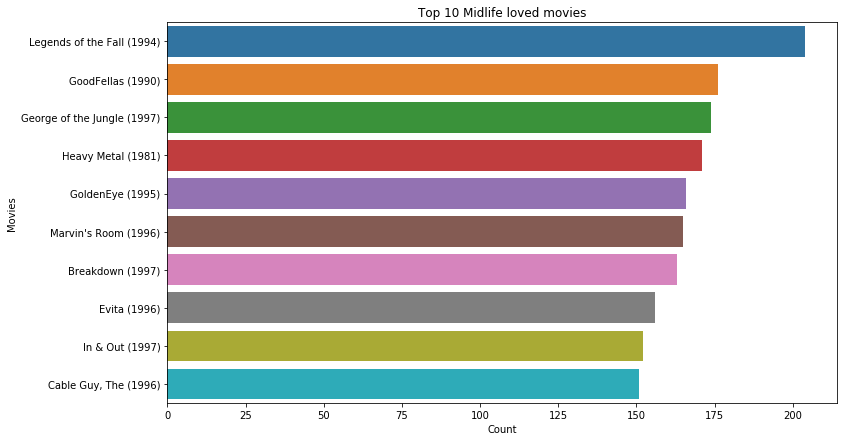

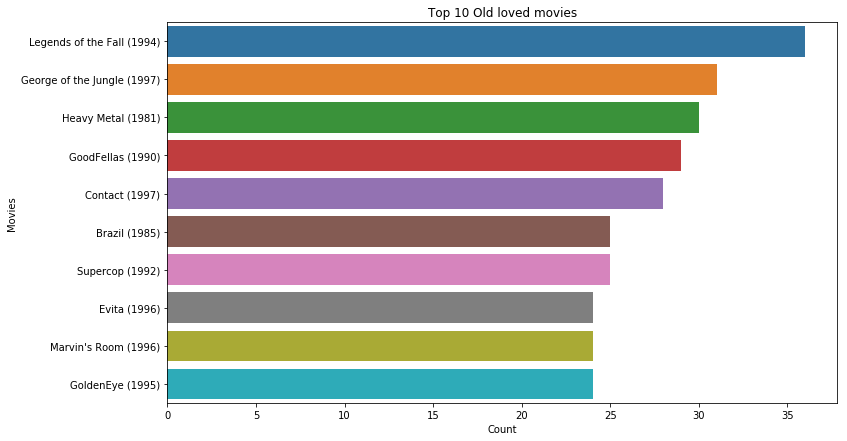

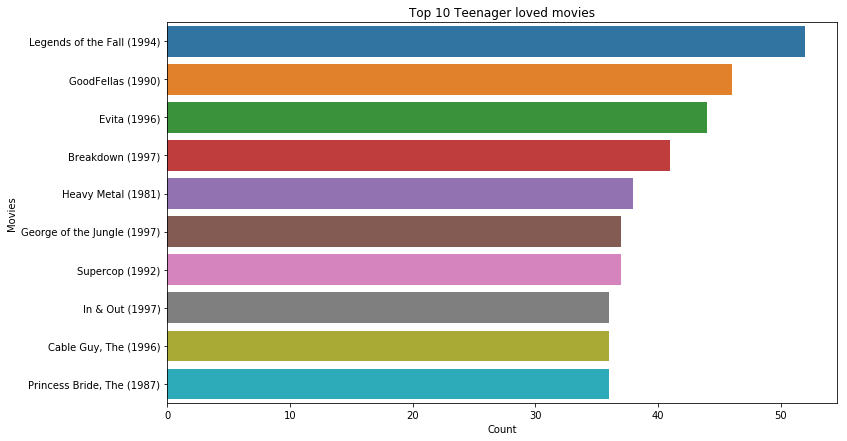

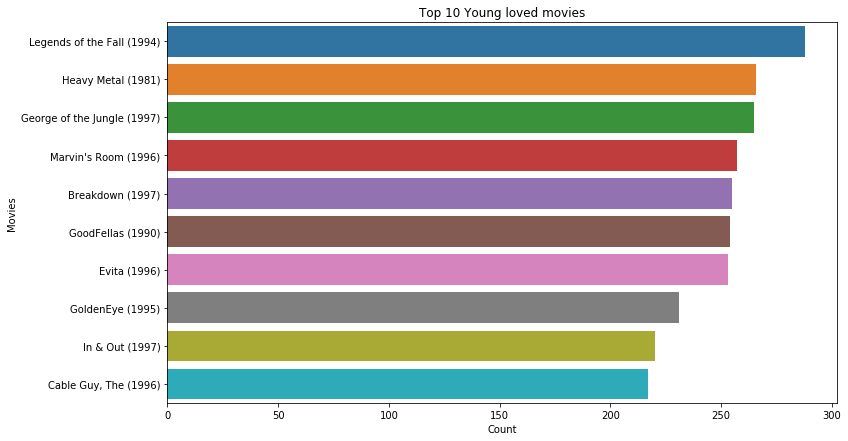

In [45]:
most_loved_movies_age_group_wise = rating_user_movie_df.groupby(['age_group','movie_id']).sum().rating

for index_label in most_loved_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_loved_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_loved_movie_titles = movie_df.iloc[top_10_userkind_loved_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_loved_movie_titles.values, top_10_userkind_loved_movies.values, f'Top 10 {index_label} loved movies')

To be honest, I haven't watched most of these movies so not quite sure what movie contains what kind of storyline :>

### <a id='QD4'>Worst movies as per user rating.</a>

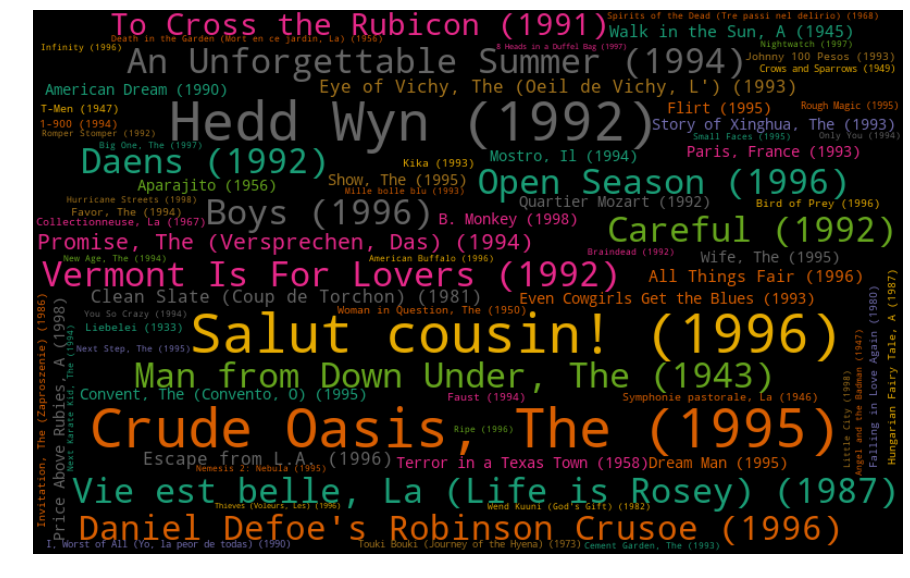

In [46]:
movies_ratings_sum = rating_user_movie_df.groupby('movie_id').sum().rating.sort_values()
movies_ratings_sum.index = movie_df.iloc[movies_ratings_sum.index].movie_title
# Will show movies with 0 < total_rating<= 10
lowest_rated_movies = movies_ratings_sum[movies_ratings_sum <= 10]


wordcloud = WordCloud(min_font_size=7, width=800, height=500, random_state=21, max_font_size=50, relative_scaling=0.5, colormap='Dark2')
# Substracted lowest_rated_movies from 11 so that we can have greater font size of least rated movies.
wordcloud.generate_from_frequencies(frequencies=(11-lowest_rated_movies).to_dict())
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Well.. all I can say is I am not amazed.

So this is it in this EDA, I have covered most of the questions that could be asked from this dataset except the ones related to user locations(zip codes), we can generate some insight from those as well, like 
- Is there any pattern in location and movie choices?
- What kind of occupats are residing in which place?
- Whether place has any impact on users being soft rater and hard rater etc.

Will do that later ;)

In [47]:
# rating_df
# movie_df
# user_df

In [48]:
rating_df.columns, 

(Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object'),)

In [49]:
top_users_g = rating_df.groupby('user_id')['rating'].count()
top_users = top_users_g.sort_values(ascending=False)[:15]
top_movies_g = rating_df.groupby('movie_id')['rating'].count()
top_movies = top_movies_g.sort_values(ascending=False)[:15]
top_users_movies = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_users_movies = top_users_movies.join(top_movies, rsuffix='_r', how='inner', on='movie_id')

In [50]:
rating_df.shape, top_users_movies.shape

((100000, 4), (190, 6))

Ratings record drastically came down after applying top-n user and movie filters. Let's check what these movies and users are:

In [51]:
top_users_movies.user_id.unique(), top_users_movies.movie_id.unique()

(array([303, 234, 276,   7,  13, 279, 393, 405, 416, 429, 450, 537, 655,
        846, 181]),
 array([181, 288, 294, 300, 286, 258,  50, 100,  56,  98, 127, 174,   1,
        121,   7]))

Top movies picked by top users:

In [52]:
top_users_df = user_df[user_df.user_id.isin(top_users_movies.user_id.unique())]
top_movies_df = movie_df[movie_df.movie_id.isin(top_users_movies.movie_id.unique())]
top_movies_df

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),1995-01-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
49,50,Star Wars (1977),1977-01-01,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
55,56,Pulp Fiction (1994),1994-01-01,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
97,98,"Silence of the Lambs, The (1991)",1991-01-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
99,100,Fargo (1996),1997-02-14,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
120,121,Independence Day (ID4) (1996),1996-07-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
126,127,"Godfather, The (1972)",1972-01-01,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
173,174,Raiders of the Lost Ark (1981),1981-01-01,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180,181,Return of the Jedi (1983),1997-03-14,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [53]:
pd.crosstab(top_users_movies.user_id, top_users_movies.movie_id, top_users_movies.rating, aggfunc=np.sum)

movie_id,1,7,50,56,98,100,121,127,174,181,258,286,288,294,300
user_id,,,,,,,,,,,,,,,
7,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,4.0,1.0,4.0
13,3.0,2.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,1.0,2.0,1.0
181,3.0,4.0,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,3.0,1.0,4.0,2.0,3.0
234,3.0,2.0,4.0,3.0,4.0,4.0,NaN,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
276,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,NaN,4.0,4.0,4.0
279,3.0,5.0,3.0,4.0,NaN,4.0,4.0,NaN,4.0,3.0,NaN,NaN,3.0,2.0,NaN
303,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0
393,3.0,4.0,5.0,2.0,NaN,1.0,4.0,NaN,NaN,4.0,4.0,NaN,3.0,4.0,NaN
405,NaN,NaN,5.0,4.0,4.0,NaN,NaN,5.0,5.0,5.0,NaN,NaN,5.0,NaN,NaN


The user/movie fields are currently non-sequential integers representing some unique ID for that entity. We need them to be sequential starting at zero

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [55]:
user_enc = LabelEncoder()
rating_df['user'] = user_enc.fit_transform(rating_df['user_id'].values)
n_users = rating_df['user'].nunique()

item_enc = LabelEncoder()
rating_df['movie'] = item_enc.fit_transform(rating_df['movie_id'].values)
n_movies = rating_df['movie'].nunique()

rating_df['rating'] = rating_df['rating'].values.astype(np.float32)

min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])

n_users, n_movies, min_rating, max_rating

(943, 1682, 1.0, 5.0)

In [56]:
# train/test split
X = rating_df[['user', 'movie']].values
y = rating_df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90000, 2), (90000,), (10000, 2), (10000,))

In [57]:
# deciding on number of factors
n_factors = 50

In [58]:
# separating user and movie lists
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Building and training a simple Neural Network:

In [59]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [60]:
def RecommenderV1(n_users, n_movies, n_factors):
    # building user input
    user = Input(shape=(1,))
    user_embed = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    user_embed = Reshape((n_factors,))(user_embed)
    
    # building movie input
    movie = Input(shape=(1,))
    movie_embed = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    movie_embed = Reshape((n_factors,))(movie_embed)
    
    # putting together user and movie input
    x = Dot(axes=1)([user_embed, movie_embed])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model


model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        47150       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        84100       input_2[0][0]                    
_____________________________________

In [61]:
history = model.fit(x=X_train_array, y=y_train, 
                    batch_size=64, epochs=5, 
                    verbose=1, validation_data=(X_test_array, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 90000 samples, validate on 10000 samples
Epoch 1/5
90000/90000 [==============================] - 3s 32us/step - loss: 9.2670 - val_loss: 1.9448
Epoch 2/5
90000/90000 [==============================] - 3s 28us/step - loss: 1.2609 - val_loss: 0.9990
Epoch 3/5
90000/90000 [==============================] - 2s 27us/step - loss: 0.9241 - val_loss: 0.9145
Epoch 4/5
90000/90000 [==============================] - 2s 27us/step - loss: 0.8496 - val_loss: 0.8886
Epoch 5/5
90000/90000 [==============================] - 2s 27us/step - loss: 0.7994 - val_loss: 0.8765


It's not a bad result, considering the simplicty of our network. Let's do few improvements:

In [62]:
from keras.layers import Add, Activation, Lambda

**Improvising embedding layer:** Add a bias term to each of the embeddings

In [63]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

**Adding a sigmoid layer** and scaling the output between the valid rating range i.e. 1-5

In [64]:
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [65]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        47150       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        84100       input_4[0][0]                    
__________________________________________________________________________________________________
reshape_3 

In [66]:
# Let's retrain 
history = model.fit(x=X_train_array, y=y_train, 
                    batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90000 samples, validate on 10000 samples
Epoch 1/5
90000/90000 [==============================] - 3s 36us/step - loss: 1.2660 - val_loss: 0.9837
Epoch 2/5
90000/90000 [==============================] - 3s 33us/step - loss: 0.8648 - val_loss: 0.8562
Epoch 3/5
90000/90000 [==============================] - 3s 32us/step - loss: 0.7267 - val_loss: 0.8270
Epoch 4/5
90000/90000 [==============================] - 3s 32us/step - loss: 0.6236 - val_loss: 0.8234
Epoch 5/5
90000/90000 [==============================] - 3s 32us/step - loss: 0.5303 - val_loss: 0.8340


In [67]:
There is a slight improvement, we can still apply more enhancements in our network to get a much better model.

SyntaxError: invalid syntax (<ipython-input-67-d7d35c9b0182>, line 1)

There is a slight improvement, we can still apply more enhancements in our network to get a much better model.